In [340]:
import numpy as np 
import random
import bisect
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import math

In [232]:
def pretty_matrix_print(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            print(round(matrix[i][j], 5), end=" ")
        print("")

In [2]:
def readJSSP(path):
    with open(path, 'r') as f:
        lines =  f.readlines()
        jobs = [[(int(machine), int(cost)) for machine, cost in zip(line.split()[0::2], line.split()[1::2])]
                for line in lines[1:] if line.strip()]
        
        return jobs

In [12]:
def calcMakespan(jobs, schedule):
    n = len(jobs)
    m = len(jobs[0])
    
    job_end = np.zeros(n, dtype=np.int) # end of prev. tasks for each job 
    machine_end = np.zeros(m, dtype=np.int) # end of prev. task for each machine
    next_task = np.zeros(n, dtype=np.int) # next task for each job
    
    
    for job in schedule:
        machine, cost = jobs[job][next_task[job]]
        
        job_start = max(machine_end[machine], job_end[job])
        
        job_end[job] = job_start + cost
        machine_end[machine] = job_start + cost
        
        next_task[job] += 1
        
    return max(machine_end)

In [13]:
def convert_tour_to_schedule(m, tour):
    return list(map(lambda x: x // m, tour))

In [26]:
def convert_schedule_to_tour(n, m, schedule):
    op_counter = [0 for _ in range(n)]
    tour = []
    #print(schedule)
    for job in schedule:
        #print(job*m + op_counter[job])
        tour.append(job*m + op_counter[job])
        op_counter[job] += 1
        
    return tour

In [29]:
def randomSolution(jobs, num_iter):
    n, m = len(jobs), len(jobs[0])
    best_tour = []
    best_makespan = 999999
    
    
    for _ in range(num_iter):
        solution = [j for j in range(n) for i in range(m)]
        random.shuffle(solution)
        makespan = calcMakespan(jobs, solution)
        
        # convert schedule to tour
        tour = convert_schedule_to_tour(n, m, solution)
        if(makespan < best_makespan):
            best_tour = tour
            best_makespan = makespan
    return best_tour, best_makespan

In [277]:
def get_probability(jobs, job_complitions, machine_complitions, pheromones, tour, next_set, beta):
    n, m = len(jobs), len(jobs[0])
    curr_operation = tour[-1]
    
    p = []
    for i in next_set:
        phero = pheromones[curr_operation][i]
        
        machine, cost = jobs[i // m][i % m]
        job_compl = max(machine_complitions[machine], job_complitions[i // m]) + cost
        p.append(phero * ((1 / cost) ** beta))
    
#    p = [pheromones[curr_operation][next_set[i]] * (1 / jobs[next_set[i] // m][next_set[i] % m][1]) ** beta 
#         for i in range(len(next_set))]
    s = sum(p)
    p = [x / s for x in p]
    return p

In [278]:
def get_probability_on_first_op(jobs, job_complitions, machine_complitions, pheromones, tour, next_set, beta):
    n, m = len(jobs), len(jobs[0])
    
    p = [pheromones[next_set[i]] * (1 / jobs[next_set[i] // m][next_set[i] % m][1]) ** beta 
         for i in range(len(next_set))]
    s = sum(p)
    p = [x / s for x in p]
    return p

In [279]:
def biased_exploitation(jobs, job_complitions, machine_complitions, pheromones, tour, next_set, beta, get_probability=get_probability):
    p = get_probability(jobs, job_complitions, machine_complitions, pheromones, tour, next_set, beta)
    prob_cumm = 0
    q = random.random()
    s=0
    #print(p)
    for i, x in enumerate(p):        
        prob_cumm += x
        if(q < prob_cumm):
            s = i
            break
    #print(s) 
    return next_set[min(s, len(next_set) - 1)]

In [280]:
def exploitation(jobs, job_complitions, machine_complitions, pheromones, tour, next_set, beta, get_probability=get_probability):
    p = get_probability(jobs, job_complitions, machine_complitions, pheromones, tour, next_set, beta)
    #print(len(tour), next_set)
    return next_set[p.index(max(p))]

In [281]:
def choose_next_operation(job, job_complitions, machine_complitions, pheromones, tour, next_set, beta, q0, get_probability=get_probability):
    q = random.random()
    next_opertaion = -1
    if(q < q0):
        next_opertaion = exploitation(jobs, job_complitions, machine_complitions, pheromones, tour, next_set, beta, get_probability)
    else:
        next_opertaion = biased_exploitation(jobs, job_complitions, machine_complitions, pheromones, tour, next_set, beta, get_probability)
    return next_opertaion

In [341]:
def optimize(jobs, beta, q0, rho, alpha, num_iter):
    n, m = len(jobs), len(jobs[0])
    
    # initialization
    best_global_tour, best_global_time = randomSolution(jobs, 2)
    tau_0 = 1 /  best_global_time # Not great, not terrible 
    print(best_global_time)
    pheromones = [[tau_0 for i in range(n * m)] for j in range(n * m)]
    pheromones_initial = [tau_0 for i in range(n * m)]
    num_ant = n 
    #pretty_matrix_print(pheromones)
    history = []
    #best_global_time = 9999999
    #best_global_tour = []
    # this is phase in which ants build their tours 
    for it in tqdm(range(num_iter)):
        first_iteration = it == 0
        # visited opertaion on each job for each ant
        visited = [[[0 for j in range(m)] for i in range(n)] for _ in range(num_ant)] 
        next_set = [[i * m for i in range(n)] for j in range(num_ant)] # first operation of each job
        time = [0 for i in range(num_ant)]
        tour = [[] for i in range(num_ant)]
        current_op = [-1 for i in range(num_ant)]
        job_complitions = [[0 for i in range(n)] for _ in range(num_ant)]
        machine_complitions = [[0 for i in range(m)] for _ in range(num_ant)]
        for i in range(n * m):
            for k in range(num_ant):
                if(first_iteration and current_op[k] == -1):
                    visited[k][k][0] = 1
                    # k*m - first operation of k-th job
                    next_set[k].append(k * m + 1)
                    next_set[k].remove(k * m)
                    tour[k].append(k * m)
                else:
                    if(current_op[k] == -1):
                        get_pr_function = get_probability_on_first_op
                        phero_matrix = pheromones_initial
                    else:
                        get_pr_function = get_probability
                        phero_matrix = pheromones

                    if(len(next_set) == 1):
                        next_operation = next_set[-1]
                    else:
                        next_operation = choose_next_operation(jobs, job_complitions[k], machine_complitions[k], phero_matrix, tour[k], next_set[k], beta, q0, get_pr_function)
                    machine_complitions[k][jobs[next_operation // m][next_operation % m][0]] += jobs[next_operation // m][next_operation % m][1]
                    job_complitions[k][next_operation // m] += jobs[next_operation // m][next_operation % m][1]
                    tour[k].append(next_operation)
                    visited[k][next_operation // m][next_operation % m] = 1
                    next_set[k].remove(next_operation)
                    if((next_operation + 1) % m != 0):
                        next_set[k].append(next_operation+1)

            # local updating

            for k in range(num_ant):
                if(not first_iteration):
                    pheromones[current_op[k]][tour[k][-1]] = (1 - rho) * pheromones[current_op[k]][tour[k][-1]] \
                                                            + rho * tau_0
                current_op[k] = tour[k][-1]

        # update global results
        for k in range(num_ant):
            time[k] = calcMakespan(jobs, convert_tour_to_schedule(m, tour[k]))
        #print("it: ", it)
        
        best_time = min(time)
        best_tour = tour[time.index(best_time)]
        
        if(best_time < best_global_time):
            best_global_time = best_time
            best_global_tour = best_tour
        #print(best_global_time)
        #print(best_global_tour)
        old_phero = [[pheromones[i][j] for j in range(len(pheromones[i]))] for i in range(len(pheromones))]
        # global update pheromones
        for i in range(len(pheromones)):
            for j in range(len(pheromones[i])):
                pheromones[i][j] *= (1 - alpha)
        
        
        pheromones_initial[best_global_tour[0]] += 10 * alpha / best_global_time
        for i in range(1, len(best_global_tour)):
            pheromones[best_global_tour[i-1]][best_global_tour[i]] += 10 * alpha / best_global_time
        
        
        #pretty_matrix_print([[pheromones[i][j] - old_phero[i][j] for j in range(len(pheromones[i]))] for i in range(len(pheromones))])
        
        
        history.append({
            "it": it,
            "best_time": best_time,
            "best_tour": best_tour
        })
        
    return best_global_time, best_global_tour, history

In [347]:
jobs = readJSSP("./instanses/abz6")
beta = 0
alpha = 0.1
rho = 0.01
q0 = 0.8
num_iter = 1000


best_time, best_tour, history = optimize(jobs, beta, q0, rho, alpha, num_iter)

best_time

1425


1119

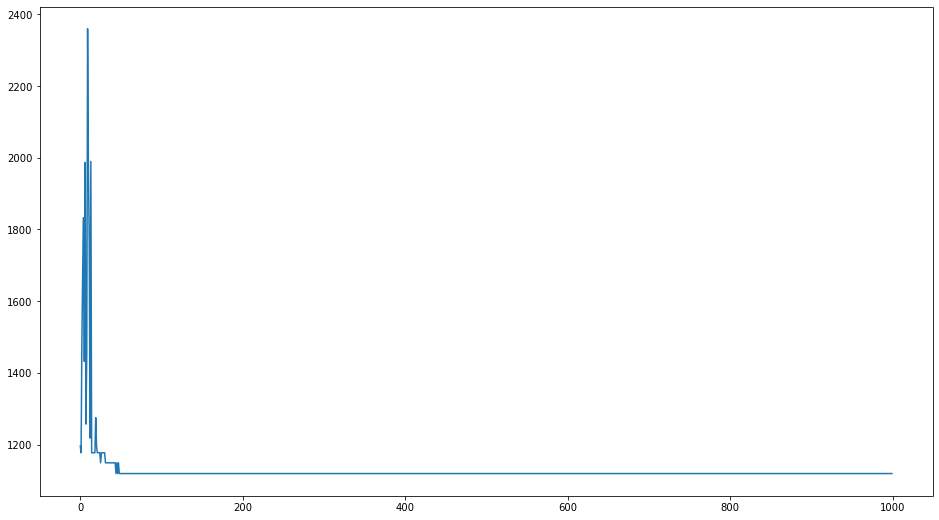

In [348]:
x = [it["it"] for it in history]
y = [it["best_time"] for it in history]

plt.figure(figsize=(16, 9))
plt.plot(x, y)

In [349]:
[(x[i], y[i]) for i in range(len(history[:100]))]

[(0, 1196),
 (1, 1177),
 (2, 1496),
 (3, 1694),
 (4, 1833),
 (5, 1432),
 (6, 1987),
 (7, 1257),
 (8, 1456),
 (9, 2360),
 (10, 1984),
 (11, 1767),
 (12, 1218),
 (13, 1990),
 (14, 1177),
 (15, 1177),
 (16, 1177),
 (17, 1177),
 (18, 1177),
 (19, 1275),
 (20, 1196),
 (21, 1177),
 (22, 1177),
 (23, 1177),
 (24, 1177),
 (25, 1149),
 (26, 1177),
 (27, 1177),
 (28, 1177),
 (29, 1177),
 (30, 1177),
 (31, 1149),
 (32, 1149),
 (33, 1149),
 (34, 1149),
 (35, 1149),
 (36, 1149),
 (37, 1149),
 (38, 1149),
 (39, 1149),
 (40, 1149),
 (41, 1149),
 (42, 1149),
 (43, 1149),
 (44, 1119),
 (45, 1149),
 (46, 1119),
 (47, 1149),
 (48, 1119),
 (49, 1119),
 (50, 1119),
 (51, 1119),
 (52, 1119),
 (53, 1119),
 (54, 1119),
 (55, 1119),
 (56, 1119),
 (57, 1119),
 (58, 1119),
 (59, 1119),
 (60, 1119),
 (61, 1119),
 (62, 1119),
 (63, 1119),
 (64, 1119),
 (65, 1119),
 (66, 1119),
 (67, 1119),
 (68, 1119),
 (69, 1119),
 (70, 1119),
 (71, 1119),
 (72, 1119),
 (73, 1119),
 (74, 1119),
 (75, 1119),
 (76, 1119),
 (77, 111